# Goldenspike, an example of an end-to-end analysis using RAIL

author: Sam Schmidt, Eric Charles, Alex Malz, others...<br>
last run successfully: April 15, 2022

This notebook demonstrates how to use a the various RAIL Modules to draw synthetic samples of fluxes by color, apply physical effects to them, train photo-Z estimators on the samples, test and validate the preformance of those estimators, and to use the RAIL summarization modules to obtain n(z) estimates based on the p(z) estimates.

### Creation 

Note that in the parlance of the Creation Module, "degradation" is any post-processing that occurs to the "true" sample generated by the create Engine.  This can include adding photometric errors, applying quality cuts, introducing systematic biases, etc.

In this notebook, we will draw both test and training samples from a RAIL Engine object. Then we will demonstrate how to use RAIL degraders to apply effects to those samples.

### Training and Estimation

The RAIL Informer modules "train" or "inform" models used to estimate p(z) given band fluxes (and potentially other information).

The RAIL Estimation modules then use those same models to actually apply the model and extract the p(z) estimates.

### p(z) Validation 

The RAIL Validator module applies various metrics 

### p(z) to n(z) Summarization

The RAIL Summarization modules convert per-galaxy p(z) posteriors to ensemble n(z) estimates. 

###  Imports

In [1]:
# Prerquisites: os, numpy, pathlib, pzflow, tables_io
import os
import numpy as np
from pathlib import Path
from pzflow.examples import get_galaxy_data
import tables_io

In [2]:
%load_ext autoreload
%autoreload 2
# Various rail modules
import rail
from rail.creation.degradation import LSSTErrorModel, InvRedshiftIncompleteness, LineConfusion, QuantityCut
from rail.creation.engines.flowEngine import FlowModeler, FlowCreator, FlowPosterior
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.core.utilStages import ColumnMapper, TableConverter

from rail.estimation.algos.bpz_lite import Inform_BPZ_lite, BPZ_lite
from rail.estimation.algos.knnpz import Inform_KNearNeighPDF, KNearNeighPDF
from rail.estimation.algos.flexzboost import Inform_FZBoost, FZBoost

from rail.estimation.algos.naiveStack import NaiveStack
from rail.estimation.algos.pointEstimateHist import PointEstimateHist

from rail.evaluation.evaluator import Evaluator



RAIL now uses ceci as a back-end, which takes care of a lot of file I/O decisions to be consistent with other choices in DESC.

This bit effectively overrides a ceci default to prevent overwriting previous results, generally good but not necessary for this demo.

The `DataStore` uses `DataHandle` objects to keep track of the connections between the various stages.  When one stage returns a `DataHandle` and then you pass that `DataHandle` to another stage, the underlying code can establish the connections needed to build a reproducilble pipeline.   

In [3]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

Here we need a few configuration parameters to deal with differences in data schema between existing PZ codes.

In [4]:
bands = ['u','g','r','i','z','y']
band_dict = {band:f'mag_{band}_lsst' for band in bands}
rename_dict = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

## Train the Flow Engine

First we need to train the normalizing flow that will serve as the engine for the notebook.

In the cell below, we load the example galaxy catalog from PZFlow and save it so that it can be used to train the flow. We also set the path where we will save the flow

In [5]:
DATA_DIR = Path().resolve() / "data"
DATA_DIR.mkdir(exist_ok=True)

catalog_file = DATA_DIR / "base_catalog.pq"
catalog = get_galaxy_data().rename(band_dict, axis=1)
tables_io.write(catalog, str(catalog_file.with_suffix("")), catalog_file.suffix[1:])

catalog_file = str(catalog_file)
flow_file = str(DATA_DIR / "trained_flow.pkl")

Now we set the parameters for the FlowModeler, i.e. the pipeline stage that trains the flow:

In [6]:
flow_modeler_params = {
    "name": "flow_modeler",
    "input": catalog_file,
    "model": flow_file,
    "flow_seed": 0,
    "phys_cols": {"redshift": [0, 3]},
    "phot_cols": {
        "mag_u_lsst": [17, 35],
        "mag_g_lsst": [16, 32],
        "mag_r_lsst": [15, 30],
        "mag_i_lsst": [15, 30],
        "mag_z_lsst": [14, 29],
        "mag_y_lsst": [14, 28],
    },
    "calc_colors": {},
}

Now we will create the flow and train it

In [7]:
flow_modeler = FlowModeler.make_stage(**flow_modeler_params)

2022-08-15 10:44:03,500 ipykernel_launcher.py absl[99063] DEBUG Initializing backend 'interpreter'
2022-08-15 10:44:03,503 ipykernel_launcher.py absl[99063] DEBUG Backend 'interpreter' initialized
2022-08-15 10:44:03,503 ipykernel_launcher.py absl[99063] DEBUG Initializing backend 'cpu'
2022-08-15 10:44:03,509 ipykernel_launcher.py absl[99063] DEBUG Backend 'cpu' initialized
2022-08-15 10:44:03,509 ipykernel_launcher.py absl[99063] DEBUG Initializing backend 'tpu_driver'
2022-08-15 10:44:03,510 ipykernel_launcher.py absl[99063] INFO Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2022-08-15 10:44:03,510 ipykernel_launcher.py absl[99063] DEBUG Initializing backend 'cuda'
2022-08-15 10:44:03,511 ipykernel_launcher.py absl[99063] INFO Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2022-08-15 10:44:03,511 ipykernel_launcher.py absl[99063] DEBUG Initializing backend 'rocm'
2022-0

In [8]:
flow_modeler.fit_model()

2022-08-15 10:44:04,650 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming prim_fun for jit in 0.00022864341735839844 sec
2022-08-15 10:44:04,651 ipykernel_launcher.py absl[99063] DEBUG Compiling prim_fun (140673379645136 for args (ShapedArray(float32[]),).
2022-08-15 10:44:04,664 ipykernel_launcher.py absl[99063] DEBUG Finished XLA compilation of broadcast_in_dim in 0.010246753692626953 sec
2022-08-15 10:44:04,666 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming prim_fun for jit in 0.0002727508544921875 sec
2022-08-15 10:44:04,667 ipykernel_launcher.py absl[99063] DEBUG Compiling prim_fun (140666760099616 for args (ShapedArray(float32[]),).
2022-08-15 10:44:04,676 ipykernel_launcher.py absl[99063] DEBUG Finished XLA compilation of broadcast_in_dim in 0.006935596466064453 sec
2022-08-15 10:44:04,678 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming prim_fun for jit in 0.0002605915069580078 sec
2022-08-15 10:44:04,679 ipy

Inserting handle into data store.  input: /phys/users/jfc20/RAIL/examples/goldenspike/data/base_catalog.pq, flow_modeler
Training 30 epochs 
Loss:


2022-08-15 10:44:05,180 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming loss_fn for jit in 0.43277478218078613 sec
2022-08-15 10:44:05,186 ipykernel_launcher.py absl[99063] DEBUG Compiling loss_fn (140666695262512) for 44 args.
2022-08-15 10:44:08,590 ipykernel_launcher.py absl[99063] DEBUG Finished XLA compilation of loss_fn in 2.5784566402435303 sec
2022-08-15 10:44:08,906 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming _threefry_split for jit in 0.0020101070404052734 sec
2022-08-15 10:44:08,907 ipykernel_launcher.py absl[99063] DEBUG Compiling _threefry_split (140666561010080 for args (ShapedArray(uint32[2]),).
2022-08-15 10:44:08,970 ipykernel_launcher.py absl[99063] DEBUG Finished XLA compilation of _threefry_split in 0.04037308692932129 sec
2022-08-15 10:44:08,973 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming _unstack for jit in 0.0007271766662597656 sec
2022-08-15 10:44:08,974 ipykernel_launcher.py absl[99

(0) 19.6684


2022-08-15 10:44:09,326 ipykernel_launcher.py absl[99063] DEBUG Finished XLA compilation of _shuffle in 0.1571345329284668 sec
2022-08-15 10:44:09,376 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming prim_fun for jit in 0.00026679039001464844 sec
2022-08-15 10:44:09,377 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming prim_fun for jit in 0.0001842975616455078 sec
2022-08-15 10:44:09,378 ipykernel_launcher.py absl[99063] DEBUG Compiling prim_fun (140666760636192 for args (ShapedArray(float32[]),).
2022-08-15 10:44:09,393 ipykernel_launcher.py absl[99063] DEBUG Finished XLA compilation of broadcast_in_dim in 0.011711597442626953 sec
2022-08-15 10:44:10,810 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming step for jit in 1.414426565170288 sec
2022-08-15 10:44:10,821 ipykernel_launcher.py absl[99063] DEBUG Compiling step (140666603573792) for 129 args.
2022-08-15 10:44:29,966 ipykernel_launcher.py absl[99063] DEBUG Finish

(1) 4.1308
(2) 3.3642
(3) 1.1700
(4) 0.9479
(5) -0.1061
(6) 0.6083
(7) -1.0593
(8) 0.6644
(9) -1.5443
(10) -0.6973
(11) -1.9570
(12) -1.8115
(13) -2.0670
(14) -1.8258
(15) -1.1367
(16) -2.0918
(17) -0.3467
(18) -1.0141
(19) -2.6147
(20) -2.5145
(21) -1.9062
(22) -1.2444
(23) -1.4500
(24) -3.0384
(25) -2.3309
(26) -3.2411
(27) -3.3246
(28) -3.1920
(29) -2.3894
(30) -2.4082
Inserting handle into data store.  model_flow_modeler: /phys/users/jfc20/RAIL/examples/goldenspike/data/inprogress_trained_flow.pkl, flow_modeler


## Make mock data

Now we will use the trained flow to create training and test data for the photo-z estimators.

For both the training and test data we will:

1. Use the Flow to produce some synthetic data
2. Use the LSSTErrorModel to add photometric errors
3. Use the FlowPosterior to estimate the redshift posteriors for the degraded sample
4. Use the ColumnMapper to rename the error columns so that they match the names in DC2.
5. Use the TableConverter to convert the data to a numpy dictionary, which will be stored in a hdf5 file with the same schema as the DC2 data

### Training sample

For the training data we are going to apply a couple of extra degradation effects to the data beyond what we do to create test data, as the training data will have some spectroscopic incompleteness.  This will allow us to see how the trained models perform with imperfect training data.

More details about the degraders are available in the `rail/examples/creation/degradation_demo.ipynb` notebook.


In [9]:
flow_creator_train = FlowCreator.make_stage(
    name='flow_creator_train', 
    model=flow_modeler.get_handle("model"), 
    n_samples=50,
    seed=1235,
)

lsst_error_model_train = LSSTErrorModel.make_stage(
    name='lsst_error_model_train',
    bandNames=band_dict, 
    seed=29,
)

inv_redshift = InvRedshiftIncompleteness.make_stage(
    name='inv_redshift',
    pivot_redshift=1.0,
)

line_confusion = LineConfusion.make_stage(
    name='line_confusion', 
    true_wavelen=5007., 
    wrong_wavelen=3727.,
    frac_wrong=0.05,
)

quantity_cut = QuantityCut.make_stage(
    name='quantity_cut',    
    cuts={'mag_i_lsst': 25.0},
)

col_remapper_train = ColumnMapper.make_stage(
    name='col_remapper_train', 
    columns=rename_dict,
)
   
table_conv_train = TableConverter.make_stage(
    name='table_conv_train', 
    output_format='numpyDict',
)

In [10]:
train_data_orig = flow_creator_train.sample(150, 1235)
train_data_errs = lsst_error_model_train(train_data_orig,seed=66)
train_data_inc = inv_redshift(train_data_errs)
train_data_conf = line_confusion(train_data_inc)
train_data_cut = quantity_cut(train_data_conf)
train_data_pq = col_remapper_train(train_data_cut)
train_data = table_conv_train(train_data_pq)

2022-08-15 10:45:56,719 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming prim_fun for jit in 0.00042819976806640625 sec
2022-08-15 10:45:56,720 ipykernel_launcher.py absl[99063] DEBUG Compiling prim_fun (140663138825936 for args (ShapedArray(float32[]),).
2022-08-15 10:45:56,740 ipykernel_launcher.py absl[99063] DEBUG Finished XLA compilation of broadcast_in_dim in 0.01423954963684082 sec
2022-08-15 10:45:56,752 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming _uniform for jit in 0.008454084396362305 sec
2022-08-15 10:45:56,753 ipykernel_launcher.py absl[99063] DEBUG Compiling _uniform (140663138827536 for args (ShapedArray(uint32[2]), ShapedArray(int32[], weak_type=True), ShapedArray(int32[], weak_type=True)).
2022-08-15 10:45:56,882 ipykernel_launcher.py absl[99063] DEBUG Finished XLA compilation of _uniform in 0.0909414291381836 sec
2022-08-15 10:45:56,884 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming prim_fun f

Inserting handle into data store.  output_flow_creator_train: inprogress_output_flow_creator_train.pq, flow_creator_train
Inserting handle into data store.  output_lsst_error_model_train: inprogress_output_lsst_error_model_train.pq, lsst_error_model_train
Inserting handle into data store.  output_inv_redshift: inprogress_output_inv_redshift.pq, inv_redshift
Inserting handle into data store.  output_line_confusion: inprogress_output_line_confusion.pq, line_confusion
Inserting handle into data store.  output_quantity_cut: inprogress_output_quantity_cut.pq, quantity_cut
Inserting handle into data store.  output_col_remapper_train: inprogress_output_col_remapper_train.pq, col_remapper_train
Inserting handle into data store.  output_table_conv_train: inprogress_output_table_conv_train.hdf5, table_conv_train


Let's examine the quantities that we've generated, we'll use the handy `tables_io` package to temporarily write to a pandas dataframe for quick writeout of the columns:

In [11]:
train_table = tables_io.convertObj(train_data.data, tables_io.types.PD_DATAFRAME)
train_table.head()

,redshift,mag_u_lsst,mag_err_u_lsst,mag_g_lsst,mag_err_g_lsst,mag_r_lsst,mag_err_r_lsst,mag_i_lsst,mag_err_i_lsst,mag_z_lsst,mag_err_z_lsst,mag_y_lsst,mag_err_y_lsst
0,0.929139,26.386290,0.264202,26.011219,0.064981,25.400499,0.037162,24.774897,0.031654,24.439359,0.041422,24.482758,0.097952
1,0.729459,26.275788,0.241332,25.964869,0.062369,25.085100,0.028151,24.257431,0.020211,24.023317,0.028700,23.936744,0.060490
2,0.150781,25.088871,0.087562,24.417219,0.016278,24.179256,0.013204,24.045854,0.016929,24.040113,0.029125,23.934374,0.060363
3,0.207901,21.273199,0.006012,19.499489,0.005013,18.716470,0.005004,18.276261,0.005004,18.151735,0.005007,18.094287,0.005020
4,1.004017,26.935462,0.408185,26.526229,0.102269,25.924684,0.059166,24.994597,0.038431,24.279500,0.035957,23.877355,0.057386


You see that we've generated redshifts, ugrizy magnitudes, and magnitude errors with names that match those in the cosmoDC2_v1.1.4_image data.

### Testing sample

For the test sample we will:

1. Use the Flow to produce some synthetic data
2. Use the LSSTErrorModel to smear the data
3. Use the FlowPosterior to estimate the redshift posteriors for the degraded sample
4. Use ColumnMapper to rename some of the columns to match DC2
5. Use the TableConverter to convert the data to a numpy dictionary, which will be stored in a hdf5 file with the same schema as the DC2 data

In [12]:
flow_creator_test = FlowCreator.make_stage(
    name='flow_creator_test',
    model=flow_modeler.get_handle("model"),
    n_samples=50,
)
      
lsst_error_model_test = LSSTErrorModel.make_stage(
    name='lsst_error_model_test',
    bandNames=band_dict,
)

flow_post_test = FlowPosterior.make_stage(
    name='flow_post_test',
    model=flow_modeler.get_handle("model"),
    column='redshift',
    grid=np.linspace(0., 5., 21),
)
                
col_remapper_test = ColumnMapper.make_stage(
    name='col_remapper_test',
    columns=rename_dict,
    hdf5_groupname='',
)

table_conv_test = TableConverter.make_stage(
    name='table_conv_test', 
    output_format='numpyDict',
)


In [13]:
test_data_orig = flow_creator_test.sample(150, 1234)
test_data_errs = lsst_error_model_test(test_data_orig,seed=58)
test_data_post = flow_post_test.get_posterior(test_data_errs, err_samples=None)
test_data_pq = col_remapper_test(test_data_errs)
test_data = table_conv_test(test_data_pq)

2022-08-15 10:45:58,617 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming prim_fun for jit in 0.00025200843811035156 sec
2022-08-15 10:45:58,618 ipykernel_launcher.py absl[99063] DEBUG Compiling prim_fun (140664094836992 for args (ShapedArray(float32[]),).
2022-08-15 10:45:58,629 ipykernel_launcher.py absl[99063] DEBUG Finished XLA compilation of broadcast_in_dim in 0.008298158645629883 sec
2022-08-15 10:45:58,633 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming prim_fun for jit in 0.0003578662872314453 sec
2022-08-15 10:45:58,633 ipykernel_launcher.py absl[99063] DEBUG Compiling prim_fun (140665212687520 for args (ShapedArray(float32[]),).
2022-08-15 10:45:58,644 ipykernel_launcher.py absl[99063] DEBUG Finished XLA compilation of broadcast_in_dim in 0.008165121078491211 sec
2022-08-15 10:45:58,647 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming prim_fun for jit in 0.0002727508544921875 sec
2022-08-15 10:45:58,647 ipy

Inserting handle into data store.  output_flow_creator_test: inprogress_output_flow_creator_test.pq, flow_creator_test
Inserting handle into data store.  output_lsst_error_model_test: inprogress_output_lsst_error_model_test.pq, lsst_error_model_test


2022-08-15 10:45:58,808 ipykernel_launcher.py absl[99063] DEBUG Finished XLA compilation of reshape in 0.008023738861083984 sec
2022-08-15 10:45:58,810 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming prim_fun for jit in 0.00023436546325683594 sec
2022-08-15 10:45:58,810 ipykernel_launcher.py absl[99063] DEBUG Compiling prim_fun (140665213099520 for args (ShapedArray(float32[1,132,1,1,1,6]),).
2022-08-15 10:45:58,821 ipykernel_launcher.py absl[99063] DEBUG Finished XLA compilation of squeeze in 0.008014440536499023 sec
2022-08-15 10:45:58,823 ipykernel_launcher.py absl[99063] DEBUG Finished tracing + transforming prim_fun for jit in 0.00029754638671875 sec
2022-08-15 10:45:58,824 ipykernel_launcher.py absl[99063] DEBUG Compiling prim_fun (140665212634992 for args (ShapedArray(float32[1,132,1,1,6]),).
2022-08-15 10:45:58,837 ipykernel_launcher.py absl[99063] DEBUG Finished XLA compilation of broadcast_in_dim in 0.010361909866333008 sec
2022-08-15 10:45:58,839 ipyk

Inserting handle into data store.  output_flow_post_test: inprogress_output_flow_post_test.hdf5, flow_post_test
Warning.  Failed to convert column 'DeviceArray' object has no attribute 'data'
Inserting handle into data store.  output_col_remapper_test: inprogress_output_col_remapper_test.pq, col_remapper_test
Inserting handle into data store.  output_table_conv_test: inprogress_output_table_conv_test.hdf5, table_conv_test


In [14]:
test_table = tables_io.convertObj(test_data.data, tables_io.types.PD_DATAFRAME)
test_table.head()

,redshift,mag_u_lsst,mag_err_u_lsst,mag_g_lsst,mag_err_g_lsst,mag_r_lsst,mag_err_r_lsst,mag_i_lsst,mag_err_i_lsst,mag_z_lsst,mag_err_z_lsst,mag_y_lsst,mag_err_y_lsst
0,1.742564,26.885539,0.392811,26.471743,0.097505,26.379589,0.088466,26.068843,0.099434,25.696648,0.125543,25.357042,0.207658
1,0.070060,23.768243,0.027594,22.934557,0.006522,22.476556,0.005686,22.292358,0.006039,22.129775,0.007186,21.987226,0.011549
2,0.430297,NaN,NaN,27.949943,0.338150,26.971789,0.148141,26.616083,0.159762,26.633655,0.276565,26.090324,0.376013
3,2.063962,27.346028,0.554047,27.424207,0.220596,27.042942,0.157459,26.958964,0.213477,26.366997,0.222106,28.059359,1.371483
4,0.630674,NaN,NaN,27.279026,0.195362,26.712515,0.118391,25.816130,0.079614,25.477869,0.103759,25.282335,0.195035


## "Inform" some estimators

More details about the process of "informing" or "training" the models used by the estimators is available in the `rail/examples/estimation/RAIL_estimation_demo.ipynb` notebook.

We use "inform" rather than "train" to generically refer to the preprocessing of any prior information.
For a machine learning estimator, that prior information is a training set, but it can also be an SED template library for a template-fitting or hybrid estimator.

In [15]:
inform_bpz = Inform_BPZ_lite.make_stage(
    name="inform_bpz",
    input=table_conv_train.get_handle("output"),
    model="bpz.pkl",
    hdf5_groupname="",
)

inform_knn = Inform_KNearNeighPDF.make_stage(
    name='inform_knn', 
    input=table_conv_train.get_handle("output"),
    nondetect_val=np.nan,
    model='knnpz.pkl', 
    hdf5_groupname='',
)

inform_fzboost = Inform_FZBoost.make_stage(
    name='inform_FZBoost', 
    input=table_conv_train.get_handle("output"),
    model='fzboost.pkl', 
    hdf5_groupname='',
)

In [16]:
inform_bpz.inform(train_data)
inform_knn.inform(train_data)
inform_fzboost.inform(train_data)

using 68 galaxies in calculation
best values for fo and kt:
[1.]
[0.3]
minimizing for type 0
[0.4 1.8 0.1] 35.036119374252586
[0.42 1.8  0.1 ] 36.259995662360076
[0.4  1.89 0.1 ] 34.70500881763812
[0.4   1.8   0.105] 35.822364334690086
[0.38       1.86       0.10333333] 34.17564376720111
[0.36  1.89  0.105] 33.4819029750441
[0.37333333 1.92       0.09833333] 33.535555363388205
[0.35555556 2.         0.10222222] 33.640714832261935
[0.32592593 1.98333333 0.1037037 ] 33.47757735522267
[0.28888889 2.03       0.10555556] 35.789288079796094
[0.35061728 1.86222222 0.10246914] 33.001141084115865
[0.34814815 1.79333333 0.10259259] 32.967883060179425
[0.31604938 1.85777778 0.10919753] 32.800407505492714
[0.28740741 1.82666667 0.11462963] 33.69656332485272
[0.3000823  1.8662963  0.10532922] 32.89313864754928
[0.3169273  1.69493827 0.10770919] 32.88199070285716
[0.27389118 1.81934156 0.11223137] 34.24278044164362
[0.3295839  1.79983539 0.10500229] 32.6340068443884
[0.34162475 1.70207133 0.10927679

## Estimate photo-z posteriors

More details about the estimators is available in the `rail/examples/estimation/RAIL_estimation_demo.ipynb` notebook.

`randomPZ` is a very simple class that does not actually predict a meaningful photo-z, instead it produces a randomly drawn Gaussian for each galaxy.<br>
`trainZ` is our "pathological" estimator, it makes a PDF from a histogram of the training data and assigns that PDF to every galaxy.<br>
`BPZ_lite` is a template-based code that outputs the posterior estimated given a specific template set and Bayesian prior. See Benitez (2000) for more details.<br>


In [17]:
estimate_bpz = BPZ_lite.make_stage(
    name='estimate_bpz', 
    hdf5_groupname='', 
    columns_file='../estimation/configs/test_bpz.columns',
    model=inform_bpz.get_handle('model'),
)

estimate_knn = KNearNeighPDF.make_stage(
    name='estimate_knn', 
    hdf5_groupname='', 
    nondetect_val=np.nan, 
    model=inform_knn.get_handle('model'),
)

estimate_fzboost = FZBoost.make_stage(
    name='test_FZBoost', 
    nondetect_val=np.nan,
    model=inform_fzboost.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='fzboost_estim'),
)

In [18]:
knn_estimated = estimate_knn.estimate(test_data)
fzboost_estimated = estimate_fzboost.estimate(test_data)
bpz_estimated = estimate_bpz.estimate(test_data)

Process 0 running estimator on chunk 0 - 150
Process 0 estimating PZ PDF for rows 0 - 150
Inserting handle into data store.  output_estimate_knn: inprogress_output_estimate_knn.hdf5, estimate_knn
Process 0 running estimator on chunk 0 - 150
Process 0 estimating PZ PDF for rows 0 - 150
Inserting handle into data store.  output_test_FZBoost: inprogress_output_test_FZBoost.hdf5, test_FZBoost
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output_estimate_bpz: inprogress_output_estimate_bpz.hdf5, estimate_bpz


## Evaluate the estimates

Now we evaluate metrics on the estimates, separately for each estimator.  

Each call to the `Evaluator.evaluate` will create a table with the various performance metrics. 
We will store all of these tables in a dictionary, keyed by the name of the estimator.

In [19]:
eval_dict = dict(bpz=bpz_estimated, fzboost=fzboost_estimated, knn=knn_estimated)
truth = test_data_orig

result_dict = {}
for key, val in eval_dict.items():
    the_eval = Evaluator.make_stage(name=f'{key}_eval', truth=truth)
    result_dict[key] = the_eval.evaluate(val, truth)

/phys/users/jfc20/RAIL/rail/evaluation/metrics/pit.py:188: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


Inserting handle into data store.  output_bpz_eval: inprogress_output_bpz_eval.hdf5, bpz_eval
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Inserting handle into data store.  output_fzboost_eval: inprogress_output_fzboost_eval.hdf5,

The Pandas DataFrame output format conveniently makes human-readable printouts of the metrics.  
This next cell will convert everything to Pandas.

In [20]:
results_tables = {key:tables_io.convertObj(val.data, tables_io.types.PD_DATAFRAME) for key,val in result_dict.items()}

In [21]:
results_tables['knn']

,PIT_KS_stat,PIT_KS_pval,PIT_CvM_stat,PIT_CvM_pval,PIT_OutRate,POINT_SimgaIQR,POINT_Bias,POINT_OutlierRate,POINT_SigmaMAD,CDE_stat,CDE_pval
0,0.202831,0.000007,0.716469,0.011509,0.21334,0.139405,-0.015104,0.066667,0.143926,-0.012861,NaN


In [22]:
results_tables['fzboost']

,PIT_KS_stat,PIT_KS_pval,PIT_CvM_stat,PIT_CvM_pval,PIT_OutRate,POINT_SimgaIQR,POINT_Bias,POINT_OutlierRate,POINT_SigmaMAD,CDE_stat,CDE_pval
0,0.299658,1.929984e-12,3.394077,7.209822e-09,0.36896,0.106362,-0.013343,0.16,0.108356,2.626195,NaN


In [23]:
results_tables['bpz']

,PIT_KS_stat,PIT_KS_pval,PIT_CvM_stat,PIT_CvM_pval,PIT_OutRate,POINT_SimgaIQR,POINT_Bias,POINT_OutlierRate,POINT_SigmaMAD,CDE_stat,CDE_pval
0,0.279832,7.017455e-11,3.325739,1.037007e-08,0.2922,0.113215,-0.037645,0.193333,0.108488,7.3842,NaN


## Summarize the per-galaxy redshift constraints to make population-level distributions

{introduce the summarizers}

First we make the stages, then execute them, then plot the output.

In [24]:
point_estimate_test = PointEstimateHist.make_stage(name='point_estimate_test')
naive_stack_test = NaiveStack.make_stage(name='naive_stack_test')

In [25]:
point_estimate_ens = point_estimate_test.summarize(eval_dict['bpz'])
naive_stack_ens = naive_stack_test.summarize(eval_dict['bpz'])

Inserting handle into data store.  output_point_estimate_test: inprogress_output_point_estimate_test.hdf5, point_estimate_test
Inserting handle into data store.  single_NZ_point_estimate_test: inprogress_single_NZ_point_estimate_test.hdf5, point_estimate_test
Inserting handle into data store.  output_naive_stack_test: inprogress_output_naive_stack_test.hdf5, naive_stack_test
Inserting handle into data store.  single_NZ_naive_stack_test: inprogress_single_NZ_naive_stack_test.hdf5, naive_stack_test


2022-08-15 10:46:58,106 ipykernel_launcher.py matplotlib.pyplot[99063] DEBUG Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-08-15 10:46:58,107 ipykernel_launcher.py matplotlib.pyplot[99063] DEBUG Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-08-15 10:46:58,109 ipykernel_launcher.py matplotlib.font_manager[99063] DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-08-15 10:46:58,109 ipykernel_launcher.py matplotlib.font_manager[99063] DEBUG findfont: score(FontEntry(fname='/astro/store/epyc/users/jfc20/local/mambaforge/envs/rail/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-08-15 10:46:58,109 ipykernel_launcher.py matplotlib.font_manager[99063] DEBUG findfont: score(FontEntry(fname='/astro/store/epyc/users/jfc20/local

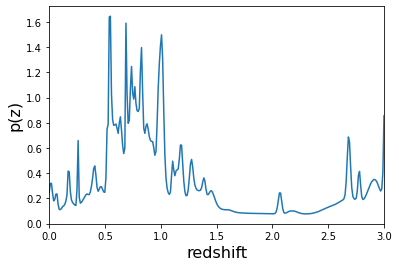

In [26]:
_ = naive_stack_ens.data.plot_native(xlim=(0,3))

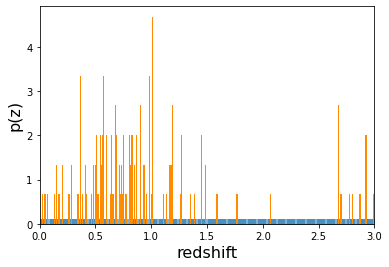

In [27]:
_ = point_estimate_ens.data.plot_native(xlim=(0,3))

### Convert this to a `ceci` Pipeline

Now that we have all these stages defined and configured, and that we have established the connections between them by passing `DataHandle` objects between them, we can build a `ceci` Pipeline.


In [31]:
import ceci
pipe = ceci.Pipeline.interactive()
stages = [
    # train the flow
    flow_modeler,
    # create the training catalog
    flow_creator_train, lsst_error_model_train, inv_redshift,
    line_confusion, quantity_cut, col_remapper_train, table_conv_train,
    # create the test catalog
    flow_creator_test, lsst_error_model_test, col_remapper_test, table_conv_test,
    # inform the estimators
    inform_bpz, inform_knn, inform_fzboost,
    # estimate posteriors
    estimate_bpz, estimate_knn, estimate_fzboost,
    # estimate n(z), aka "summarize"
    point_estimate_test, naive_stack_test,
]
for stage in stages:
    pipe.add_stage(stage)

In [32]:
pipe.initialize(dict(input=catalog_file), dict(output_dir='.', log_dir='.', resume=False), None)

(({'flow_modeler': <Job flow_modeler>,
   'flow_creator_test': <Job flow_creator_test>,
   'lsst_error_model_test': <Job lsst_error_model_test>,
   'col_remapper_test': <Job col_remapper_test>,
   'table_conv_test': <Job table_conv_test>,
   'flow_creator_train': <Job flow_creator_train>,
   'lsst_error_model_train': <Job lsst_error_model_train>,
   'inv_redshift': <Job inv_redshift>,
   'line_confusion': <Job line_confusion>,
   'quantity_cut': <Job quantity_cut>,
   'col_remapper_train': <Job col_remapper_train>,
   'table_conv_train': <Job table_conv_train>,
   'inform_FZBoost': <Job inform_FZBoost>,
   'test_FZBoost': <Job test_FZBoost>,
   'inform_knn': <Job inform_knn>,
   'estimate_knn': <Job estimate_knn>,
   'inform_bpz': <Job inform_bpz>,
   'estimate_bpz': <Job estimate_bpz>,
   'naive_stack_test': <Job naive_stack_test>,
   'point_estimate_test': <Job point_estimate_test>},
   LSSTErrorModel parameters:
   
   Model for bands: mag_u_lsst, mag_g_lsst, mag_r_lsst, mag_i_lsst,

In [33]:
pipe.save('tmp_goldenspike.yml')

### Read back the pipeline and run it

In [34]:
pr = ceci.Pipeline.read('tmp_goldenspike.yml')

ConstructorError: could not determine a constructor for the tag 'tag:yaml.org,2002:python/object:rail.core.data.Hdf5Handle'
  in "tmp_goldenspike_config.yml", line 195, column 10

In [ ]:
pr.run()

# Clean up:

Finally, you'll notice that we've written a large number of temporary files in the course of running this demo, to delete these and clean up the directory just run the `cleanup.sh` script in this directory to delete the data files.